# Credit Card Fraud Detection

This notebook implements a complete workflow for detecting fraudulent credit card transactions. It includes data loading, preprocessing, exploratory analysis, model training, and evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set plot style
sns.set(style="whitegrid")

In [2]:
FILEPATH = 'creditcard.csv'
TARGET_COLUMN = 'Class'
COLUMNS_TO_DROP_FOR_X = ['Time', TARGET_COLUMN]

print(f"Attempting to load data from: {FILEPATH}")
if os.path.exists(FILEPATH):
    try:
        df = pd.read_csv(FILEPATH)
        print("Data loaded successfully.")
        print(f"Original DataFrame shape: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())

        if 'Amount' in df.columns:
            print("\nScaling 'Amount' feature using StandardScaler...")
            scaler = StandardScaler()
            df_scaled = df.copy()
            df_scaled['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
            print("Scaled 'Amount' in df_scaled.")

            print("Preparing X (features) and y (target)...")
            y = df_scaled[TARGET_COLUMN]
            X = df_scaled.drop(columns=COLUMNS_TO_DROP_FOR_X)
            feature_names = X.columns.tolist()
            print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
            print("Features ready for Cell 3.")

        else:
            print("\n'Amount' column not found. Skipping scaling.")
            print("Preparing X (features) and y (target)...")
            y = df[TARGET_COLUMN]
            X = df.drop(columns=COLUMNS_TO_DROP_FOR_X)
            feature_names = X.columns.tolist()
            print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
            print("Features ready for Cell 3.")

    except Exception as e:
        print(f"Error loading CSV file: {e}")
        df = None 
        X = None
        y = None
else:
    print(f"Error: File not found at {FILEPATH}")
    df = None 
    X = None
    y = None

if df is not None:
    print("\nDescriptive Statistics (Original Data):")
    print(df.describe())

Attempting to load data from: creditcard.csv
Data loaded successfully.
Original DataFrame shape: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  


--- Cell 2: Outlier Analysis (Amount) and Correlation Analysis ---

--- Analyzing Outliers in 'Amount' using IQR ---


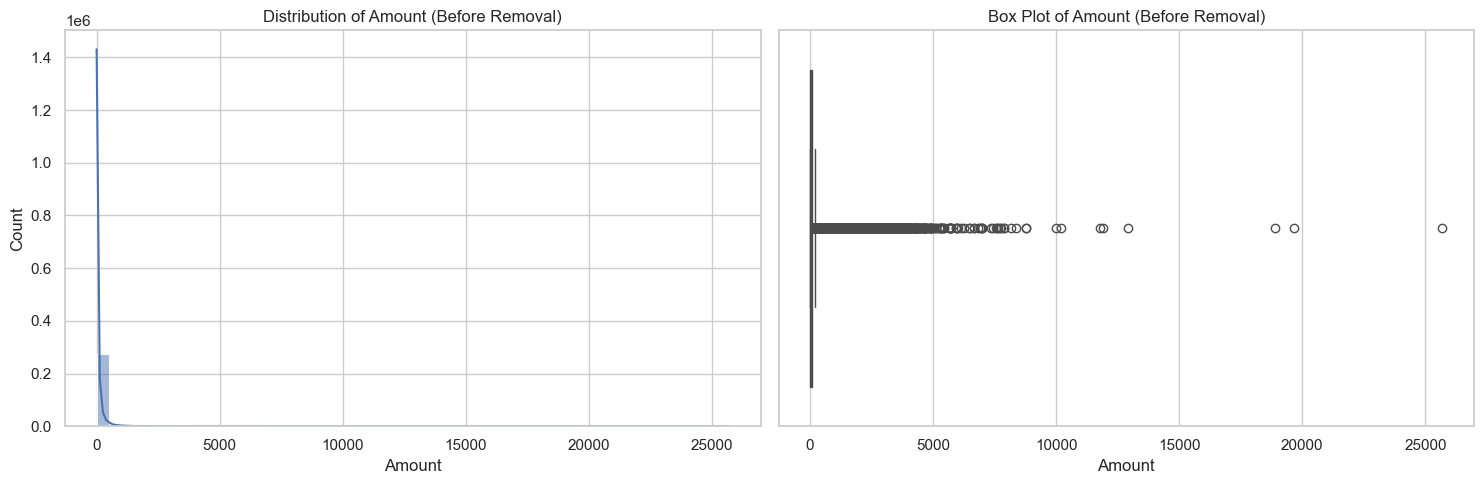

IQR for Amount: 71.56, Lower Bound: -101.75, Upper Bound: 184.51
Number of outliers detected in Amount: 31904
Percentage of outliers: 11.20%
Shape after removing Amount outliers: (252903, 31)


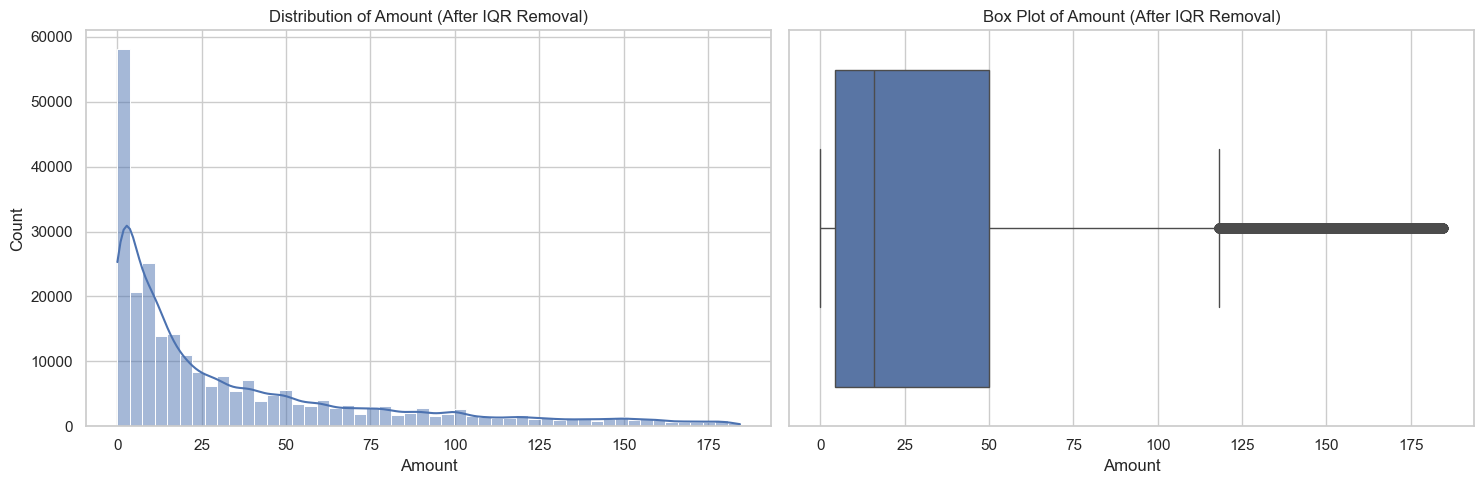


*Caution*: Removing outliers might remove actual fraud cases.

--- Correlation Analysis ---


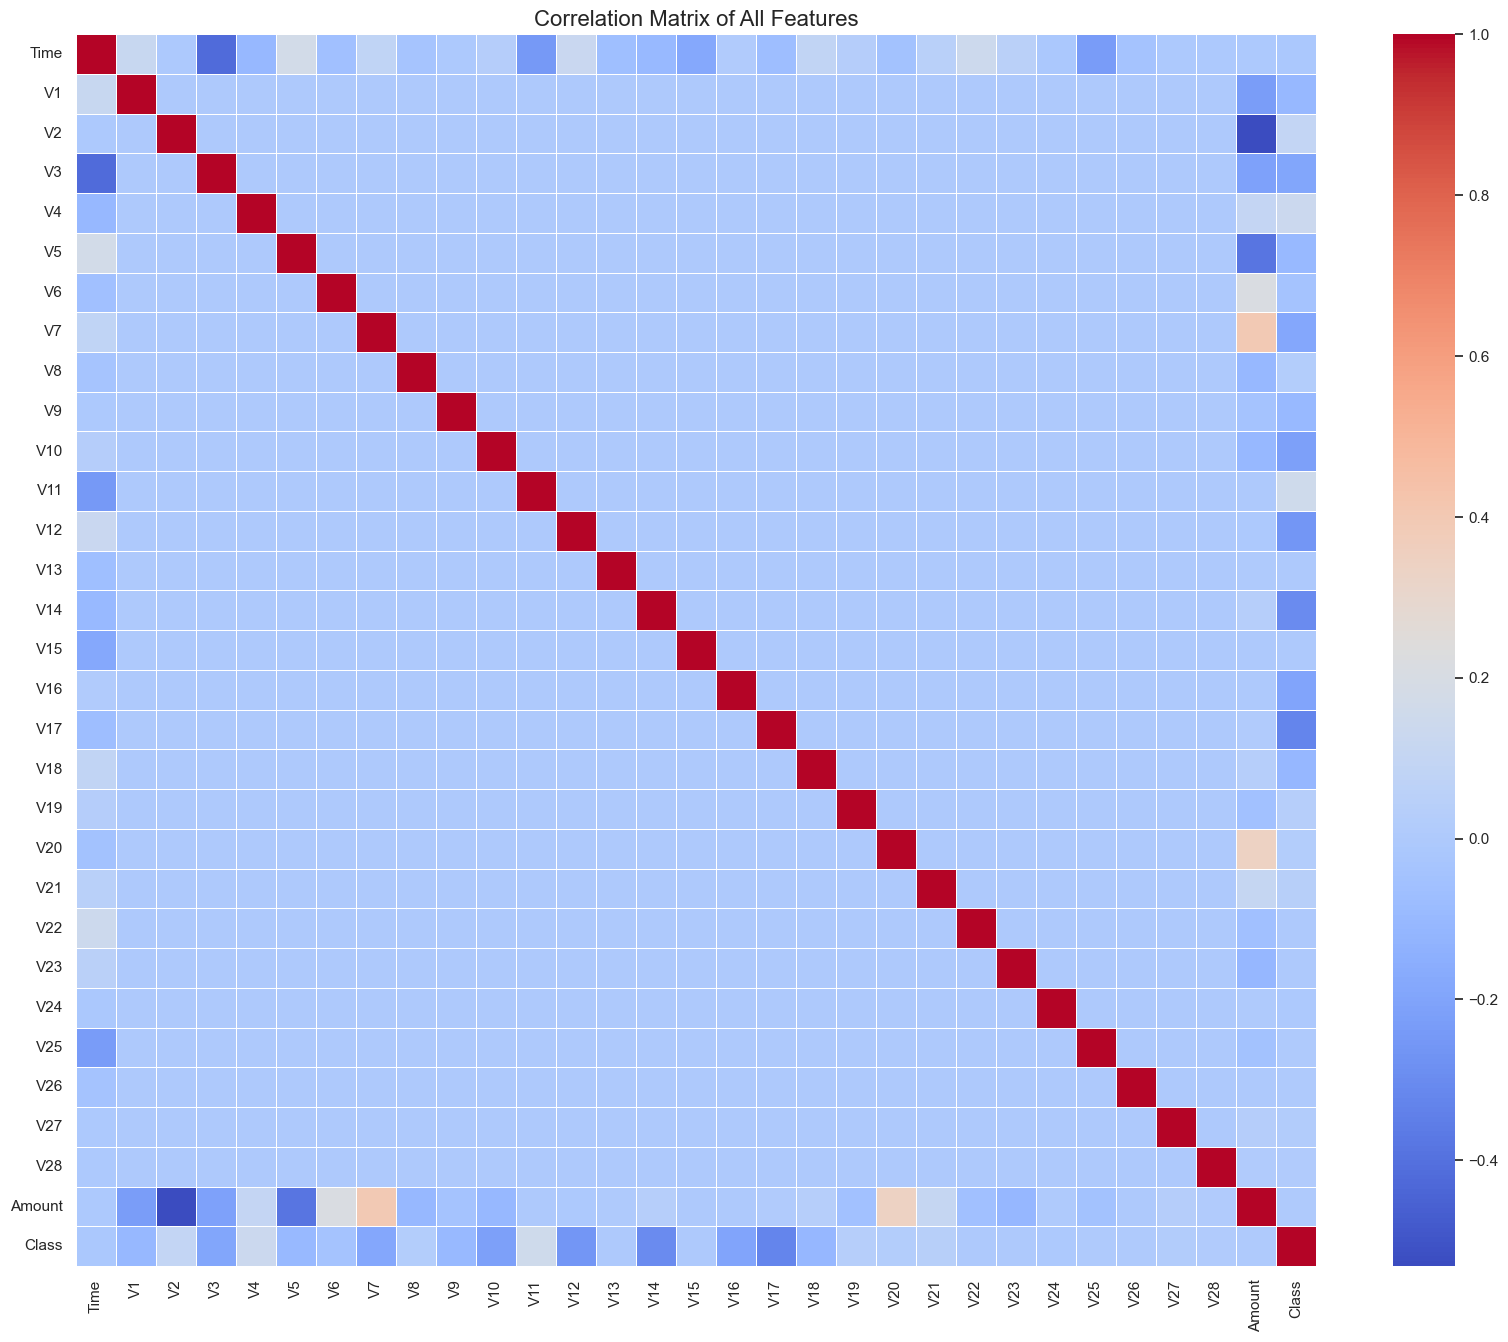


Correlation with Target Variable (Class):
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


C:\Users\elect\AppData\Local\Temp\ipykernel_5304\3397475787.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_corr_filtered.values, y=class_corr_filtered.index, palette='vlag')


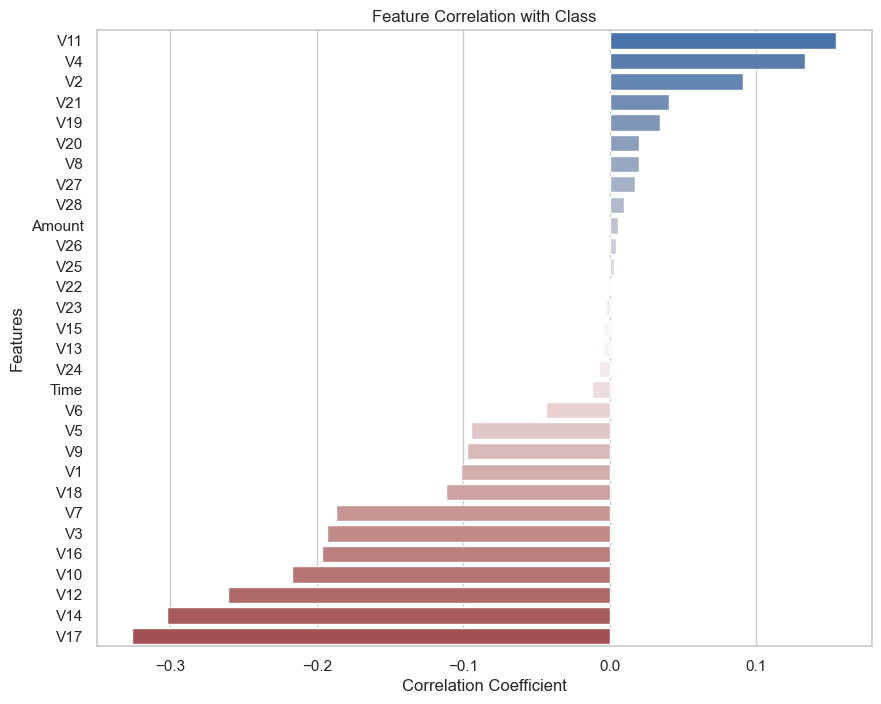

In [3]:
if df is not None:
    print("\n--- Cell 2: Outlier Analysis (Amount) and Correlation Analysis ---")

    amount_col = 'Amount'
    if amount_col in df.columns:
        print(f"\n--- Analyzing Outliers in '{amount_col}' using IQR ---")

        # Visualize distribution BEFORE removal
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[amount_col], bins=50, kde=True)
        plt.title(f'Distribution of {amount_col} (Before Removal)')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[amount_col])
        plt.title(f'Box Plot of {amount_col} (Before Removal)')
        plt.tight_layout()
        plt.show()

        # Calculate IQR bounds
        Q1 = df[amount_col].quantile(0.25)
        Q3 = df[amount_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print(f"IQR for {amount_col}: {IQR:.2f}, Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

        # Identify outliers
        outliers = df[(df[amount_col] < lower_bound) | (df[amount_col] > upper_bound)]
        print(f"Number of outliers detected in {amount_col}: {len(outliers)}")
        print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")

        # Create a DataFrame without outliers for visualization
        df_no_outliers = df[(df[amount_col] >= lower_bound) & (df[amount_col] <= upper_bound)]
        print(f"Shape after removing {amount_col} outliers: {df_no_outliers.shape}")

        # Visualize distribution AFTER removal
        if len(outliers) > 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            sns.histplot(df_no_outliers[amount_col], bins=50, kde=True)
            plt.title(f'Distribution of {amount_col} (After IQR Removal)')
            plt.subplot(1, 2, 2)
            sns.boxplot(x=df_no_outliers[amount_col])
            plt.title(f'Box Plot of {amount_col} (After IQR Removal)')
            plt.tight_layout()
            plt.show()
        else:
            print("No outliers removed based on IQR criteria.")
        print("\n*Caution*: Removing outliers might remove actual fraud cases.")
    else:
        print(f"\nColumn '{amount_col}' not found, skipping outlier analysis.")


    print("\n--- Correlation Analysis ---")
    correlation_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5)
    plt.title('Correlation Matrix of All Features', fontsize=16)
    plt.show()

    # Analyze correlation with the target variable
    if TARGET_COLUMN in correlation_matrix:
        class_corr = correlation_matrix[TARGET_COLUMN].sort_values(ascending=False)
        print(f"\nCorrelation with Target Variable ({TARGET_COLUMN}):")
        print(class_corr)

        # Plot correlations with target
        plt.figure(figsize=(10, 8))
        class_corr_filtered = class_corr.drop(TARGET_COLUMN)
        sns.barplot(x=class_corr_filtered.values, y=class_corr_filtered.index, palette='vlag')
        plt.title(f'Feature Correlation with {TARGET_COLUMN}')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Features')
        plt.show()
    else:
        print(f"Target column '{TARGET_COLUMN}' not found for correlation analysis.")

else:
    print("Cell 2 cannot run because the DataFrame 'df' was not loaded successfully in Cell 1.")


--- Cell 3: Feature Selection ---

--- Method 1: SelectKBest (Selecting top 15 features) ---
Feature Scores (ANOVA F-value):
   Feature         Score
16     V17  33979.168593
13     V14  28695.547788
11     V12  20749.822361
9      V10  14057.979985
15     V16  11443.349428
2       V3  11014.508305
6       V7  10349.605408
10     V11   6999.355047
3       V4   5163.832114
17     V18   3584.380605
0       V1   2955.668946
8       V9   2746.600273
4       V5   2592.357929
1       V2   2393.401678
5       V6    543.510578
20     V21    465.916251
18     V19    344.990997
19     V20    114.999731
7       V8    112.548287
26     V27     88.045296
27     V28     25.901405
23     V24     14.850932
28  Amount      9.033345
12     V13      5.947672
25     V26      5.653653
14     V15      5.080193
24     V25      3.116062
22     V23      2.053476
21     V22      0.184706

Top 15 features selected by SelectKBest:
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V

C:\Users\elect\AppData\Local\Temp\ipykernel_5304\2247027679.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=feature_scores_kbest.head(20), palette='viridis')


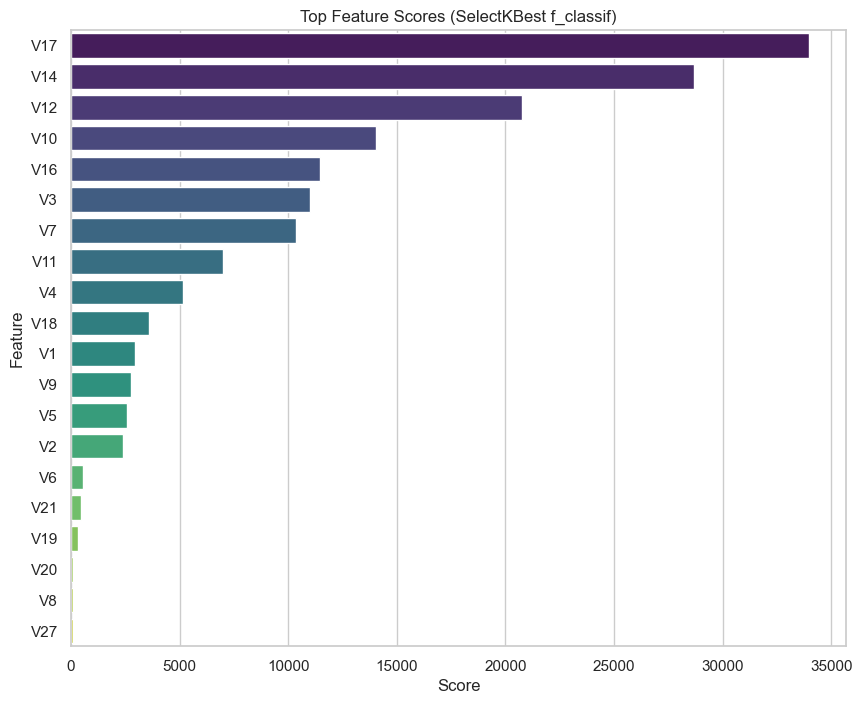


--- Method 2: Random Forest Importance (Selecting top 15 features) ---
Training Random Forest for feature importance...
Training complete.
Feature Importances:
   Feature  Importance
9      V10    0.148571
13     V14    0.130519
3       V4    0.125310
11     V12    0.103963
10     V11    0.098258
16     V17    0.062764
15     V16    0.046584
6       V7    0.046329
2       V3    0.043851
1       V2    0.019383
20     V21    0.016178
17     V18    0.014628
8       V9    0.012833
28  Amount    0.012396
18     V19    0.011771
4       V5    0.011004
7       V8    0.009413
19     V20    0.009269
5       V6    0.008658
14     V15    0.008175
26     V27    0.008018
25     V26    0.008005
27     V28    0.007909
12     V13    0.007251
22     V23    0.007084
0       V1    0.006269
21     V22    0.006106
24     V25    0.005559
23     V24    0.003940

Top 15 features selected by Random Forest Importance:
['V10', 'V14', 'V4', 'V12', 'V11', 'V17', 'V16', 'V7', 'V3', 'V2', 'V21', 'V18', 'V9', 'Amount

C:\Users\elect\AppData\Local\Temp\ipykernel_5304\2247027679.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(20), palette='magma')


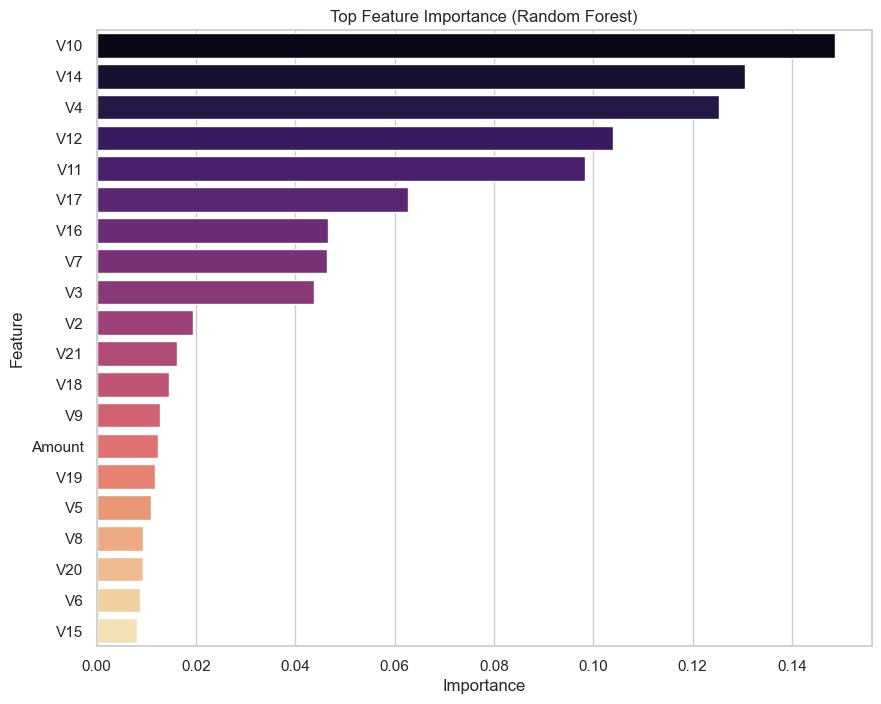

In [4]:
if X is not None and y is not None:
    print("\n--- Cell 3: Feature Selection ---")
    NUM_FEATURES_TO_SELECT = 15

    # --- 1. SelectKBest using f_classif ---
    print(f"\n--- Method 1: SelectKBest (Selecting top {NUM_FEATURES_TO_SELECT} features) ---")
    if NUM_FEATURES_TO_SELECT > X.shape[1]:
        print(f"Warning: k={NUM_FEATURES_TO_SELECT} exceeds available features ({X.shape[1]}). Selecting all.")
        k_kbest = X.shape[1]
    else:
        k_kbest = NUM_FEATURES_TO_SELECT

    selector_kbest = SelectKBest(score_func=f_classif, k=k_kbest)
    selector_kbest.fit(X, y)

    # Get scores and selected names
    scores_kbest = np.nan_to_num(selector_kbest.scores_)
    feature_scores_kbest = pd.DataFrame({'Feature': feature_names, 'Score': scores_kbest})
    feature_scores_kbest = feature_scores_kbest.sort_values(by='Score', ascending=False)
    selected_features_kbest = feature_names_kbest = feature_scores_kbest['Feature'].head(k_kbest).tolist()

    print("Feature Scores (ANOVA F-value):")
    print(feature_scores_kbest)
    print(f"\nTop {k_kbest} features selected by SelectKBest:")
    print(selected_features_kbest)

    # Visualize scores
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=feature_scores_kbest.head(20), palette='viridis')
    plt.title(f'Top Feature Scores (SelectKBest f_classif)')
    plt.show()


    # --- 2. Random Forest Feature Importance ---
    print(f"\n--- Method 2: Random Forest Importance (Selecting top {NUM_FEATURES_TO_SELECT} features) ---")
    if NUM_FEATURES_TO_SELECT > X.shape[1]:
        print(f"Warning: k={NUM_FEATURES_TO_SELECT} exceeds available features ({X.shape[1]}). Selecting all.")
        k_rf = X.shape[1]
    else:
        k_rf = NUM_FEATURES_TO_SELECT

    # Train RF model (use class_weight='balanced' for imbalanced data)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    print("Training Random Forest for feature importance...")
    rf_model.fit(X, y)
    print("Training complete.")

    # Get importances
    importances_rf = rf_model.feature_importances_
    feature_importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
    feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
    selected_features_rf = feature_importance_rf['Feature'].head(k_rf).tolist()

    print("Feature Importances:")
    print(feature_importance_rf)
    print(f"\nTop {k_rf} features selected by Random Forest Importance:")
    print(selected_features_rf)

    # Visualize importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(20), palette='magma')
    plt.title(f'Top Feature Importance (Random Forest)')
    plt.show()

else:
    print("Cell 3 cannot run because features 'X' and target 'y' were not prepared successfully in Cell 1.")

In [5]:
# Load the dataset
# Ensure that 'creditcard.csv' is in your working directory
data = pd.read_csv('creditcard.csv')
print('Dataset shape:', data.shape)
data.head()

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Basic data exploration
print('Missing values by column:')
print(data.isnull().sum())

print('\nData summary:')
print(data.describe())

Missing values by column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Data summary:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.

In [7]:
# Drop the 'Time' column
data.drop('Time', axis=1, inplace=True)

# Scale the 'Amount' feature
scaler = StandardScaler()
data['Amount_Scaled'] = scaler.fit_transform(data[['Amount']])
data.drop('Amount', axis=1, inplace=True)

# Rearrange columns so that the target is the last column
target = 'Class'
cols = [col for col in data.columns if col != target] + [target]
data = data[cols]

print('Columns after preprocessing:', data.columns.tolist())

Columns after preprocessing: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Scaled', 'Class']


In [8]:
# Split the data into features and target
X = data.drop(target, axis=1)
y = data[target]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (227845, 29)
Test set shape: (56962, 29)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



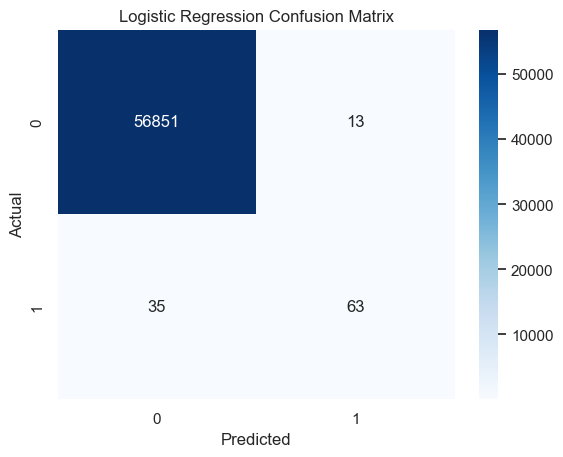

Logistic Regression ROC AUC Score: 0.9559728259621236


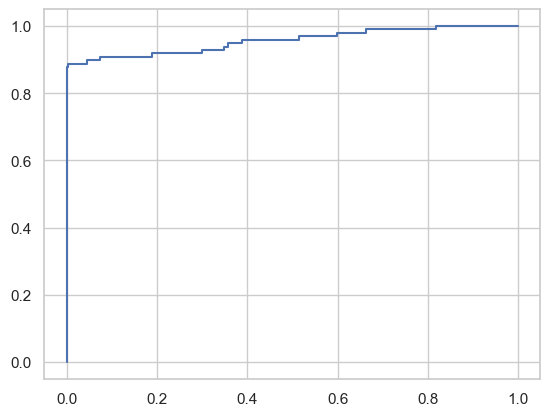

In [9]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lr = log_reg.predict(X_test)
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC score
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
roc_score_lr = roc_auc_score(y_test, y_prob_lr)
print('Logistic Regression ROC AUC Score:', roc_score_lr)

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_score_lr:.2f})')

In [10]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
roc_score_rf = roc_auc_score(y_test, y_prob_rf)
print('Random Forest ROC AUC Score:', roc_score_rf)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_score_rf:.2f})')

# Plot ROC curves for both models
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

KeyboardInterrupt: 

## Conclusion

In this notebook, both Logistic Regression and Random Forest models were evaluated, with ROC curves and classification reports to compare their performance. Further improvements may include hyperparameter tuning, handling class imbalance with techniques such as SMOTE, and testing with additional models.